In [1]:

import os

import pandas as pd
import numpy as np

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


In [2]:
abt = pd.read_csv("../Resources/Analytical_Base_Table.csv")
abt.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,30.5,33.6,0.627000,50.0,1
1,1.0,85.0,66.0,29.0,30.5,26.6,0.351000,31.0,0
2,8.0,183.0,64.0,23.0,30.5,23.3,0.672000,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167000,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,0.471876,33.0,1


## Models Training

## Let's start by splitting our dataframe into separate objects:

y for the target varibale

X for the input features

In [3]:
X = abt.drop(["class"], axis=1)

y = abt["class"]

# display shapes of X and y
print(X.shape, y.shape)

(768, 8) (768,)


In [4]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

[]

In [6]:
# distribution of churn
col1 = y.value_counts()
col2 = y.value_counts(normalize=True)*100
pd.DataFrame(data={'Target':[0,1],'Diabetes':col1,'Diabetes %':col2.round(2)})

,Target,Diabetes,Diabetes %
0,0,500,65.1
1,1,268,34.9


## Create a Train Test Split

We will continue with splitting our data into separate training and test sets.

30% of observations will be set aside for the test set

the rest, 70%, will be used as the training set

In [7]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

537 231 537 231


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 491 to 265
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    537 non-null    float64
 1   plas    537 non-null    float64
 2   pres    537 non-null    float64
 3   skin    537 non-null    float64
 4   test    537 non-null    float64
 5   mass    537 non-null    float64
 6   pedi    537 non-null    float64
 7   age     537 non-null    float64
dtypes: float64(8)
memory usage: 37.8 KB


## Pre-processing Pipeline
 
 ##Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [9]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 1, 2, 3, 4, 5, 6, 7]


In [10]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features) 

[]


In [11]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [])])

In [12]:
# Import classifier
from sklearn.neighbors import KNeighborsClassifier

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  KNeighborsClassifier())

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [])])),
                ('smote', SMOTE(random_state=10)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [13]:
 # Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
kn_param_grid = {
    'kneighborsclassifier__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'kneighborsclassifier__weights' : ['uniform', 'distance'],
    'kneighborsclassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
kn_grid = GridSearchCV(model, kn_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [14]:
kn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.694 total time=   0.0s
[CV 2/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.741 total time=   0.0s
[CV 3/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.729 total time=   0.0s
[CV 4/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.617 total time=   0.0s
[CV 5/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.664 total time=   0.0s
[CV 1/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=distance;, score=0.694 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6,
                                                                          7]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14, 15,
                                                               16, 17, 18, 19,
                                                               20, 21, 22, 23,
                                                               24, 25, 26, 27,
                                                               28, 29, 30],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy', verbose=3)

In [15]:
print(kn_grid.best_params_)

{'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 22, 'kneighborsclassifier__weights': 'uniform'}


In [16]:
print(kn_grid.best_score_)

0.722533748701973


In [17]:
print(f"Training Data Score: {kn_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {kn_grid.score(X_test, y_test)}")

Training Data Score: 0.750465549348231
Testing Data Score: 0.7186147186147186


In [18]:
predictions = kn_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [1 0 1 0 0 0 0 1 0 1]
First 10 Actual labels: [0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


C:\Users\pavanksu2009\AppData\Local\Temp\ipykernel_11624\1443231627.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"First 10 Actual labels: {y_test[:10].tolist()}")


In [19]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,1,0
1,0,0
2,1,0
3,0,1
4,0,0
...,...,...
226,1,0
227,1,1
228,0,0
229,0,0


In [20]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[105  39]
 [ 26  61]]


In [21]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.73 0.27]
 [0.3  0.7 ]]


In [22]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       144
           1       0.61      0.70      0.65        87

    accuracy                           0.72       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.73      0.72      0.72       231



In [23]:
pred = kn_grid.predict(X_test[:1])

In [24]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [1]
Actual Labels: [0]


C:\Users\pavanksu2009\AppData\Local\Temp\ipykernel_11624\3302990698.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(f"Actual Labels: {list(y_test[:1])}")


In [25]:
import joblib

filename = '../models/challa_knn.sav'
joblib.dump(kn_grid, filename)

['../models/challa_knn.sav']

In [26]:
kn_model = joblib.load(filename)
print(kn_model.score(X_test, y_test))

0.7186147186147186


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [28]:
model_performance_classification_sklearn(kn_grid, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,0.750466,0.81768,0.594378,0.688372


In [29]:
model_performance_classification_sklearn(kn_grid, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.718615,0.701149,0.61,0.652406


In [30]:
df1 = pd.DataFrame(model_performance_classification_sklearn(kn_grid, X_test, y_test).T).reset_index().rename(columns={'index':'Metrics_names',0:'Testing_Metrics'})
df1

,Metrics_names,Testing_Metrics
0,Accuracy,0.718615
1,Recall,0.701149
2,Precision,0.610000
3,F1,0.652406


In [31]:
df2 = pd.DataFrame(model_performance_classification_sklearn(kn_grid, X_train, y_train).T).reset_index().rename(columns={'index':'Metrics_names',0:'Training_Metrics'})
df2

,Metrics_names,Training_Metrics
0,Accuracy,0.750466
1,Recall,0.817680
2,Precision,0.594378
3,F1,0.688372


In [32]:
Output_df = pd.merge(df2, df1, on='Metrics_names')
display(Output_df)

,Metrics_names,Training_Metrics,Testing_Metrics
0,Accuracy,0.750466,0.718615
1,Recall,0.817680,0.701149
2,Precision,0.594378,0.610000
3,F1,0.688372,0.652406


In [33]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

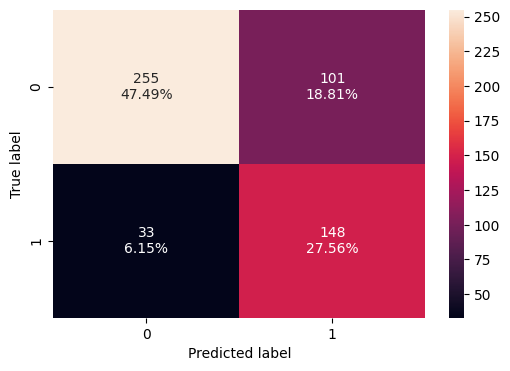

In [34]:
confusion_matrix_sklearn(kn_grid, X_train, y_train)

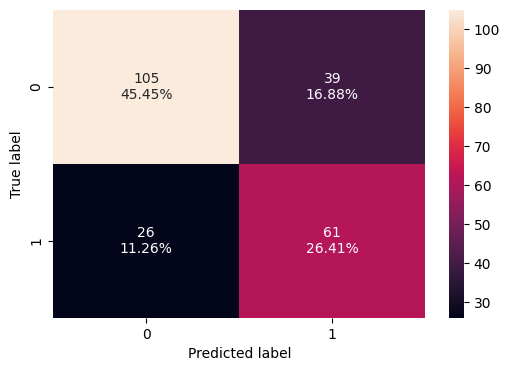

In [35]:
confusion_matrix_sklearn(kn_grid, X_test, y_test)